Zaimplementuj aplikację szacującą czas ukończenia półmaratonu dla zadanych danych

1. Umieść dane w Digital Ocean Spaces

1. Napisz notebook, który będzie Twoim pipelinem do trenowania modelu

   - czyta dane z Digital Ocean Spaces
   - czyści je
   - trenuje model (dobierz odpowiednie metryki [feature selection])
   - nowa wersja modelu jest zapisywana lokalnie i do Digital Ocean Spaces

1. Aplikacja
   - opakuj model w aplikację streamlit
   - wdróż (deploy) aplikację za pomocą Digital Ocean AppPlatform
   - wejściem jest pole tekstowe, w którym użytkownik się przedstawia, mówi o tym
     jaka jest jego płeć, wiek i tempo na 5km
   - jeśli użytkownik podał za mało danych, wyświetl informację o tym jakich danych brakuje
   - za pomocą LLM (OpenAI) wyłuskaj potrzebne dane, potrzebne dla Twojego modelu
     do określenia, do słownika (dictionary lub JSON)
   - tę część podepnij do Langfuse, aby zbierać metryki o skuteczności działania LLM'a


In [8]:
import os
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from pycaret.regression import setup
from dotenv import load_dotenv
import boto3

load_dotenv()


True

In [9]:
s3 = boto3.client(
    "s3",
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    endpoint_url=os.getenv("AWS_ENDPOINT_URL_S3"),
)
BUCKET_NAME = "runner"


In [10]:
def cut_percentiles(df: pd.DataFrame, column_name: str, *, lower: float = 0.005, higher: float = 0.995) -> pd.DataFrame:
    lower_percentile = df[column_name].quantile(lower)
    upper_percentile = df[column_name].quantile(higher)

    return df[(df[column_name] >= lower_percentile) & (df[column_name] <= upper_percentile)]

In [11]:
def cut_IQR(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    Q3 = df[column_name].quantile(0.75)
    Q1 = df[column_name].quantile(0.25)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

In [12]:
# Snippet pomocniczy - zmiana czasu na sekundy


def convert_time_to_seconds(time):
    if pd.isnull(time) or time in ["DNS", "DNF"]:
        return None
    time = time.split(":")
    return int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])

In [13]:
df_hw23 = pd.read_csv("halfmarathon_wroclaw_2023__final.csv", sep=";")
df_hw24 = pd.read_csv("halfmarathon_wroclaw_2024__final.csv", sep=";")

df_hw = pd.concat([df_hw23, df_hw24], ignore_index=True)

df_hw.shape

(21957, 27)

In [14]:
df_hw.sample(10)

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
14003,5054.0,7594,ADRIAN,WRZESZCZ,ŁÓDŹ,POL,HTF LUDWIK SIKORSKI,M,4257.0,M50,...,5.550000,01:24:33,5064.0,5.726667,01:54:28,5035.0,5.983333,0.024533,02:01:14,5.747017
3098,3099.0,4682,PIOTR,BOROWY,MĘDŁÓW,POL,WRZUCAM BIEG,M,2707.0,M40,...,5.146667,01:18:04,2762.0,5.430000,01:49:07,3027.0,6.210000,0.076067,01:54:50,5.443628
10778,1829.0,1997,DOROTA,PRZĘZAK,WŁÓKI,POL,NaN,K,149.0,K20,...,4.746667,01:13:56,1898.0,4.936667,01:39:37,1788.0,5.136667,0.005800,01:45:41,5.009876
1756,1757.0,344,AGATA,LISTOWSKA,BRZEG,POL,KOTWICA BRZEG,K,151.0,K40,...,4.986667,01:15:49,2235.0,5.020000,01:41:54,1822.0,5.216667,0.004267,01:46:23,5.043059
11618,2669.0,6761,MARKKU,HAVONEN,WROCŁAW,POL,RAF RUNNER,M,2392.0,M50,...,4.933333,01:16:06,2428.0,5.360000,01:44:08,2637.0,5.606667,0.049333,01:50:32,5.239788
6156,6157.0,8079,PIOTR,BŁOŃSKI,SMOLEC,POL,POLISH WINGS,M,4785.0,M50,...,6.076667,01:32:02,6058.0,6.650000,02:08:11,6126.0,7.230000,0.104467,02:14:54,6.394880
5414,5415.0,6384,JANUSZ,TORZEWSKI,WARSZAWA,POL,BEMOWO BIEGA,M,4348.0,M50,...,5.910000,01:29:10,5498.0,6.026667,02:02:46,5418.0,6.720000,0.051733,02:08:51,6.108082
21893,NaN,2660,PAWEŁ,ŁAMASZ,NaN,NaN,Chłopaki Na Szlaki,M,NaN,M30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNS,NaN
17744,8795.0,8170,ADAM,KILAN,SMOLEC,POL,NaN,M,6497.0,M50,...,6.240000,01:38:52,8576.0,7.350000,02:17:42,8815.0,7.766667,0.117200,02:25:57,6.918701
13079,4130.0,3203,BOGUMIŁ,ZIÓŁKOWSKI,WROCŁAW,POL,-,M,3565.0,M40,...,4.920000,01:18:27,3092.0,5.693333,01:50:29,3998.0,6.406667,0.095267,01:57:37,5.575571


In [15]:
df_hw.columns

Index(['Miejsce', 'Numer startowy', 'Imię', 'Nazwisko', 'Miasto', 'Kraj',
       'Drużyna', 'Płeć', 'Płeć Miejsce', 'Kategoria wiekowa',
       'Kategoria wiekowa Miejsce', 'Rocznik', '5 km Czas',
       '5 km Miejsce Open', '5 km Tempo', '10 km Czas', '10 km Miejsce Open',
       '10 km Tempo', '15 km Czas', '15 km Miejsce Open', '15 km Tempo',
       '20 km Czas', '20 km Miejsce Open', '20 km Tempo', 'Tempo Stabilność',
       'Czas', 'Tempo'],
      dtype='object')

In [16]:
# df_training = df_hw[["Płeć", "Kategoria wiekowa", "Rocznik", "5 km Czas", "Czas"]]
df_training = df_hw[["Płeć", "Rocznik", "5 km Czas", "Czas"]]
df_training["5 km Czas"] = df_training["5 km Czas"].apply(convert_time_to_seconds)
df_training["Czas"] = df_training["Czas"].apply(convert_time_to_seconds)
df_training["Czas"] = df_training.groupby("Płeć")["Czas"].transform(lambda x: x.fillna(x.mean()))
df_training.dropna(inplace=True)
df_training["Rocznik"] = df_training["Rocznik"].astype("int32")
df_training.sample(10)

,Płeć,Rocznik,5 km Czas,Czas
16226,M,1975,1625.0,8020.0
10103,M,1984,1370.0,6046.0
1398,M,1995,1437.0,6238.0
5501,M,1994,1773.0,7772.0
15968,M,1984,1717.0,7918.0
10257,M,1981,1433.0,6127.0
9735,M,1987,1385.0,5857.0
6876,M,1978,1737.0,8633.0
5821,M,1977,1802.0,7931.0
4211,M,1984,1633.0,7242.0


In [17]:
# df_training["Kategoria wiekowa"].unique()

In [18]:
m = df_training[df_training["Płeć"] == "M"]["Czas"].mean()
k = df_training[df_training["Płeć"] == "K"]["Czas"].mean()
print(f"{m=} | {k=}")

m=7150.372727272727 | k=7989.856976969228


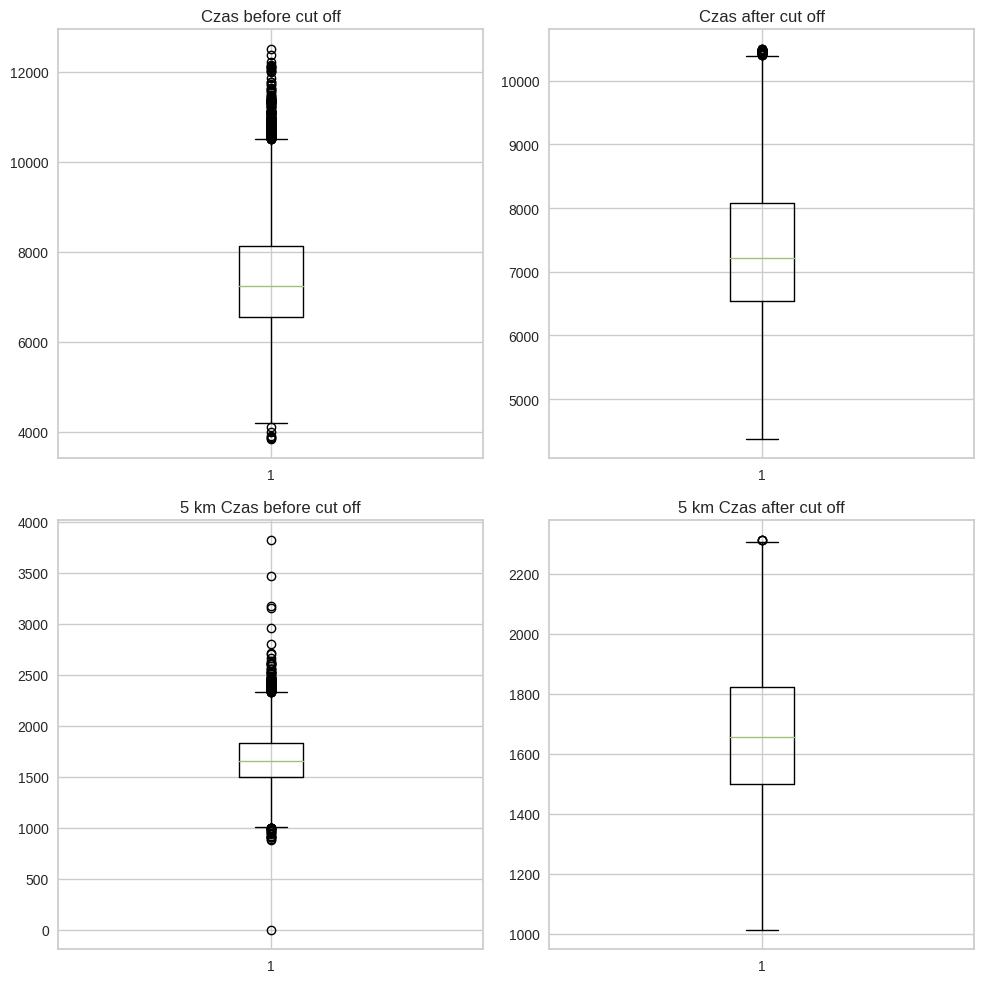

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].boxplot(df_training["Czas"])
axes[0, 0].set_title("Czas before cut off")
axes[1, 0].boxplot(df_training["5 km Czas"])
axes[1, 0].set_title("5 km Czas before cut off")

# cut off the outliers
df_training = cut_IQR(df_training, "Czas")
df_training = cut_IQR(df_training, "5 km Czas")

# df_training = cut_percentiles(df_training, "Czas")
# df_training = cut_percentiles(df_training, "5 km Czas")

axes[0, 1].boxplot(df_training["Czas"])
axes[0, 1].set_title("Czas after cut off")
axes[1, 1].boxplot(df_training["5 km Czas"])
axes[1, 1].set_title("5 km Czas after cut off")

plt.tight_layout()
plt.show()


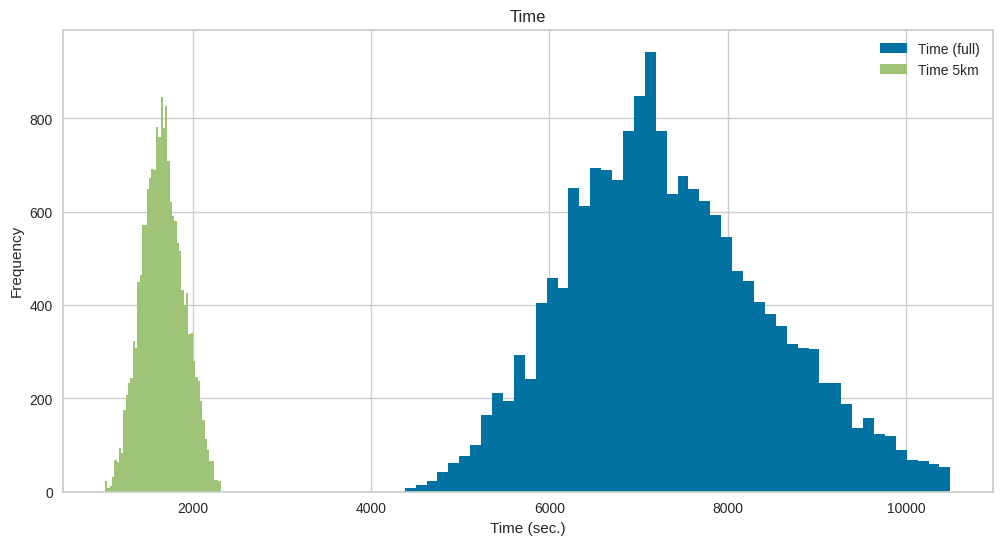

In [20]:
plt.figure(figsize=(12, 6))
plt.hist(df_training["Czas"], bins=50, label="Time (full)")
plt.hist(df_training["5 km Czas"], bins=50, label="Time 5km")
plt.xlabel("Time (sec.)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Time")
plt.show()


In [21]:
df_training.shape

(17632, 4)

In [22]:
df_training["Płeć"].value_counts(normalize=True)

Płeć
M    0.715517
K    0.284483
Name: proportion, dtype: float64

In [23]:
ESTIMATOR = "MAE"
exp = setup(
    df_training,
    target="Czas",
    categorical_features=["Płeć"],
    # categorical_features=["Kategoria wiekowa", "Płeć"],
    numeric_features=["5 km Czas", "Rocznik"],
    session_id=1337,
    fold_strategy="stratifiedkfold",  # Use stratified sampling
    # fold_groups="Płeć",
    fold=10,
    # normalize=True,
    # transformation=True,
)

,Description,Value
0,Session id,1337
1,Target,Czas
2,Target type,Regression
3,Original data shape,"(17632, 4)"
4,Transformed data shape,"(17632, 4)"
5,Transformed train set shape,"(12342, 4)"
6,Transformed test set shape,"(5290, 4)"
7,Numeric features,2
8,Categorical features,1
9,Preprocess,True


In [24]:
best_models = exp.compare_models(
    n_select=3,
    exclude=["lightgbm"],  # does not work on my machine
    sort=ESTIMATOR,
)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,286.8522,158635.2611,398.0473,0.8776,0.0510,0.0376,0.0120
gbr,Gradient Boosting Regressor,289.7598,155397.2589,393.9904,0.8801,0.0506,0.0383,0.0510
br,Bayesian Ridge,290.8593,156373.9347,395.2255,0.8793,0.0508,0.0384,0.0100
en,Elastic Net,290.8626,156375.0680,395.2269,0.8793,0.0508,0.0384,0.0100
omp,Orthogonal Matching Pursuit,290.8657,156377.9198,395.2306,0.8793,0.0508,0.0384,0.0110
lasso,Lasso Regression,290.8756,156382.2769,395.2361,0.8793,0.0508,0.0384,0.1060
llar,Lasso Least Angle Regression,290.8756,156382.2768,395.2361,0.8793,0.0508,0.0384,0.0100
lar,Least Angle Regression,290.9061,156379.2817,395.2322,0.8793,0.0508,0.0384,0.0100
ridge,Ridge Regression,290.9061,156379.2735,395.2321,0.8793,0.0508,0.0384,0.0100
lr,Linear Regression,290.9061,156379.2817,395.2322,0.8793,0.0508,0.0384,0.1700


In [25]:
best_tuned_model = [exp.tune_model(m, optimize=ESTIMATOR) for m in best_models]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,272.9201,148357.6739,385.1723,0.8868,0.0496,0.0358
1,295.1795,180748.4542,425.1452,0.8624,0.0543,0.0386
2,283.8742,150689.0814,388.1869,0.8830,0.0499,0.0374
3,285.8849,162113.2763,402.6329,0.8698,0.0519,0.0375
4,283.3425,156961.2607,396.1834,0.8746,0.0510,0.0373
5,295.6799,165131.3169,406.3635,0.8758,0.0519,0.0385
6,287.7784,154695.5814,393.3136,0.8784,0.0507,0.0378
7,288.1455,158427.5319,398.0296,0.8790,0.0513,0.0377
8,272.8559,146013.9844,382.1178,0.8889,0.0485,0.0355


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,281.2252,148379.3647,385.2004,0.8868,0.0498,0.0373
1,302.7835,178518.7519,422.5148,0.8641,0.0542,0.0400
2,287.7979,145567.9586,381.5337,0.8870,0.0493,0.0383
3,288.0965,156971.2612,396.1960,0.8739,0.0511,0.0381
4,289.1344,155248.7223,394.0161,0.8760,0.0510,0.0384
5,296.8788,158330.5169,397.9077,0.8809,0.0511,0.0392
6,292.4257,151510.1910,389.2431,0.8809,0.0504,0.0388
7,294.9260,157051.0767,396.2967,0.8800,0.0514,0.0391
8,278.3146,144459.4219,380.0782,0.8901,0.0483,0.0365


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,280.2120,146809.0945,383.1567,0.8879,0.0496,0.0371
1,301.1277,177318.5358,421.0921,0.8650,0.0539,0.0397
2,290.3949,149326.6591,386.4281,0.8841,0.0499,0.0386
3,287.7260,156290.6979,395.3362,0.8745,0.0511,0.0381
4,290.3085,155146.5373,393.8865,0.8761,0.0509,0.0386
5,296.7530,158362.6131,397.9480,0.8809,0.0509,0.0391
6,293.1529,151269.0973,388.9333,0.8810,0.0503,0.0388
7,291.2656,154547.5202,393.1253,0.8819,0.0508,0.0384
8,276.8495,141884.1758,376.6752,0.8921,0.0479,0.0363


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [26]:
best_model = exp.compare_models(best_models + best_tuned_model, sort=ESTIMATOR)
exp.predict_model(best_model)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
3,Huber Regressor,286.5616,160316.4443,400.1440,0.8763,0.0513,0.0375,0.0100
0,Huber Regressor,286.8522,158635.2611,398.0473,0.8776,0.0510,0.0376,0.0140
1,Gradient Boosting Regressor,289.7598,155397.2589,393.9904,0.8801,0.0506,0.0383,0.0520
4,Gradient Boosting Regressor,289.7598,155397.2589,393.9904,0.8801,0.0506,0.0383,0.0510
5,Bayesian Ridge,290.8583,156373.9809,395.2255,0.8793,0.0508,0.0384,0.0090
2,Bayesian Ridge,290.8593,156373.9347,395.2255,0.8793,0.0508,0.0384,0.0100


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,291.7915,166662.8495,408.2436,0.8695,0.0523,0.0381


,Płeć,Rocznik,5 km Czas,Czas,prediction_label
12888,M,1958,1654.0,7006.0,7240.915216
7812,M,1946,2302.0,9727.0,10173.132092
7453,M,1994,2038.0,9160.0,8973.246981
475,M,1990,1301.0,5611.0,5640.463508
891,M,1979,1419.0,5967.0,6175.495808
...,...,...,...,...,...
7194,K,1992,1985.0,8905.0,8733.788980
10817,M,1974,1432.0,6362.0,6234.903838
9755,M,1989,1332.0,5870.0,5780.791463
2430,M,1987,1583.0,6633.0,6916.248778


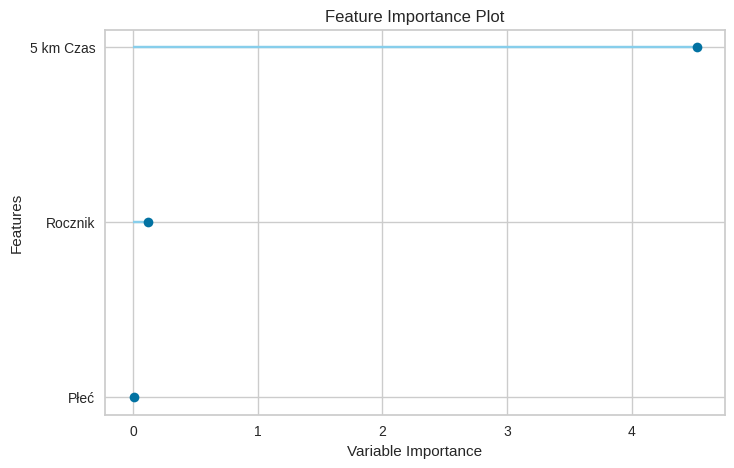

In [27]:
exp.plot_model(best_model, plot="feature")


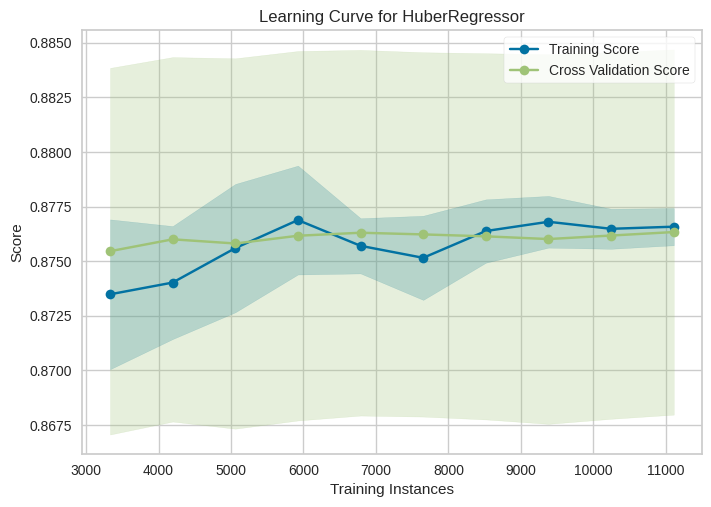

In [28]:
exp.plot_model(
    best_model,
    plot="learning",
)


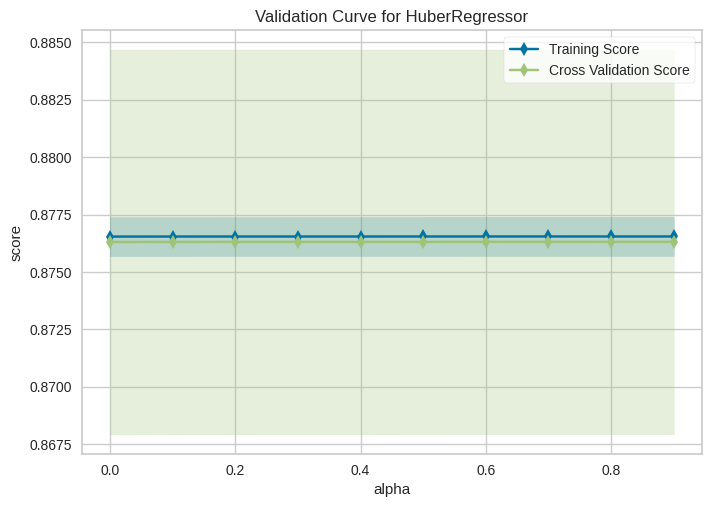

In [29]:
exp.plot_model(best_model, plot="vc")

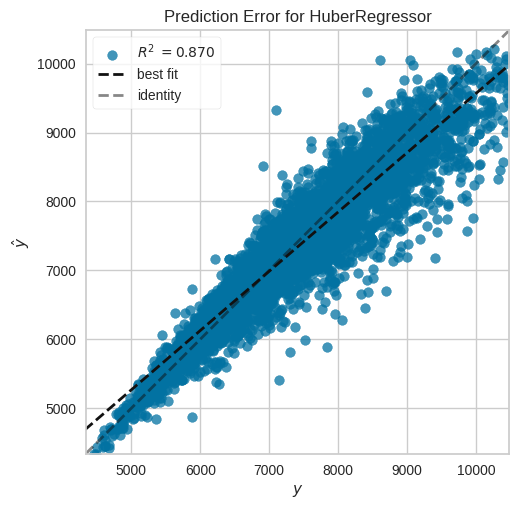

In [30]:
exp.plot_model(best_model, plot="error")

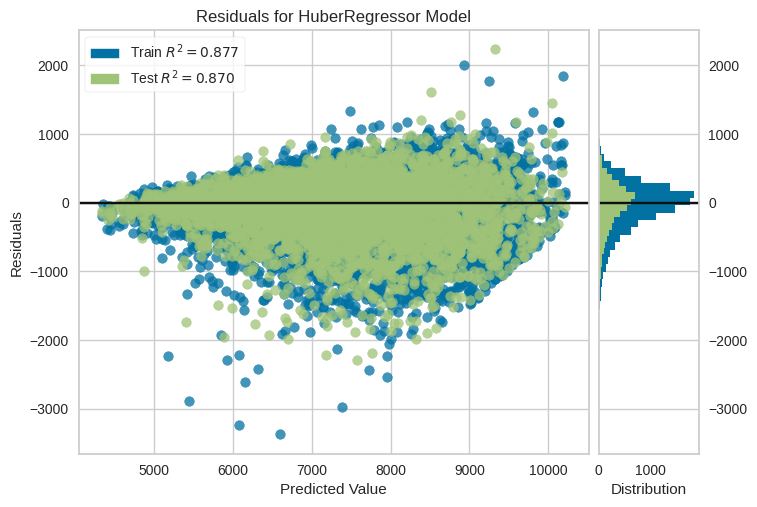

In [31]:
exp.plot_model(best_model)


In [32]:
final_model = exp.finalize_model(best_model)
final_model

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['5 km Czas', 'Rocznik'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['Płeć'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('ordinal_encoding',
                 TransformerWrapper(include=['Płeć'],
                                    transformer=OrdinalEncoder(cols=['Płeć'],
                                                               handle_missing='return_nan',
                                                               mapping=[{'col': 'Płeć',
                                                                         'data_type': dtype('O'),
                                                                         'mapping': K      0
M      1
NaN   -1
dtype: int64}]))),
                ('clean_column_names',
                 TransformerWrapper(transformer=CleanColumnNames())),
                ('actual_estimator', HuberRegressor(alpha=0.001, epsilon=1))])

In [33]:
exp.save_model(final_model, "runner_model")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['5 km Czas', 'Rocznik'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Płeć'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_encoding',
                  TransformerWrapper(include=['Płeć'],
                                     transformer=OrdinalEncoder(cols=['Płeć'],
                                                                handle_missing='return_nan',
                                                                mapping=[{'col': 'Płeć',
                                                                          'data_type': dtype('O'),
                                                                          'mapping': K      0
 M      1
 NaN   -1
 dtype: int64}]))),
       

In [34]:
s3.upload_file(
    Filename="halfmarathon_wroclaw_2023__final.csv", Bucket=BUCKET_NAME, Key="halfmarathon_wroclaw_2023__final.csv"
)
s3.upload_file(
    Filename="halfmarathon_wroclaw_2024__final.csv", Bucket=BUCKET_NAME, Key="halfmarathon_wroclaw_2024__final.csv"
)
s3.upload_file(Filename="runner_model.pkl", Bucket=BUCKET_NAME, Key="runner_model.pkl")

In [35]:
def get_agectg(sex: str, year: int) -> str:
    return sex + str(max(min((datetime.now().year - year) // 10 * 10, 80), 20)).upper()

In [36]:
def seconds_to_time(seconds):
    if pd.isnull(seconds):
        return None
    h = int(seconds // 3600)
    m = int((seconds % 3600) // 60)
    s = int(seconds % 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

In [37]:
pred_data = {"Płeć": "M", "Rocznik": 1979, "5 km Czas": 25 * 60}


dft = pd.DataFrame(pred_data, index=[0])
dft["Kategoria wiekowa"] = dft.apply(lambda row: get_agectg(row["Płeć"], row["Rocznik"]), axis=1)
pred_time = exp.predict_model(final_model, data=dft).loc[0, "prediction_label"]
print(dft)


print(seconds_to_time(pred_time))

  Płeć  Rocznik  5 km Czas Kategoria wiekowa
0    M     1979       1500               M40
01:49:00


In [38]:
def predict_finish_time(df: pd.DataFrame, age_ctg: str, sex: str, time_5km: int):
    df_pred = df[["Kategoria wiekowa", "Płeć", "5 km Czas", "Czas"]].copy()
    df_pred["Czas_seconds"] = df_pred["Czas"].apply(convert_time_to_seconds)
    df_pred["5 km Czas_seconds"] = df_pred["5 km Czas"].apply(convert_time_to_seconds)

    df_filtered = df_pred[(df_pred["Kategoria wiekowa"] == age_ctg) & (df_pred["Płeć"] == sex)]
    if len(df_filtered) == 0:
        df_filtered = df_pred
    df_filtered = df_filtered.dropna(subset=["5 km Czas_seconds", "Czas_seconds"])

    # check for exact match
    exact_match = df_filtered[df_filtered["5 km Czas_seconds"] == time_5km]
    if len(exact_match) > 0:  # count the mean if more than one
        mean_time_seconds = exact_match["Czas_seconds"].mean()
        return mean_time_seconds

    # find closest one
    df_filtered["time_diff"] = abs(df_filtered["5 km Czas_seconds"] - time_5km)
    closest = df_filtered.loc[df_filtered["time_diff"].idxmin()]

    return closest["Czas_seconds"]

In [39]:
# Example usage
pred_time = predict_finish_time(df_hw, "M40", "M", 25 * 60)
print(f"Predicted finish time: {seconds_to_time(pred_time)}")

Predicted finish time: 01:48:28
